# What questions we will ask in this class
1. Difference in terms of consistency of different methods. Euler, RK4
2. Difference in terms of zero stability (does it provide access to unstable schemes, in other words, customized method?)
3. Difference in terms of absolute stability
4. Stiff equations
5. Hamiltonian systems
6. New: Interplay between machine learning and ODEs.

In [1]:
# Load packages
using LinearAlgebra
using DifferentialEquations
using PyPlot

## Consistency

How accurate is a method given a certain step size?

Consider the initial value problem
$$
\begin{split}
u'_{1} &= u_{1},\\
u'_{2} &= u_{1} - u_{2},\\
\end{split}
$$
with initial condition $(u_{1}(0),u_{2}(0))=(1,1)$.


In [2]:
function f_linear(du,u,p,t)
    du[1] = u[1]
    du[2] = u[1] - u[2]
end
    
u0=[1.0,1.0]
tspan = (0.0,1.0)
tvec = LinRange(tspan[1],tspan[2],11)
dt = tvec[2]-tvec[1]
prob = ODEProblem(f_linear,u0,tspan)
sol_Euler = solve(prob,Euler(),dt=dt);
sol_AB3 = solve(prob,AB3(),dt=dt);
# Note that the default RK4 has adaptive step size control 
sol_RK4 = solve(prob,RK4(),dt=dt,adaptive=false); 

Plot the solution as well as the error

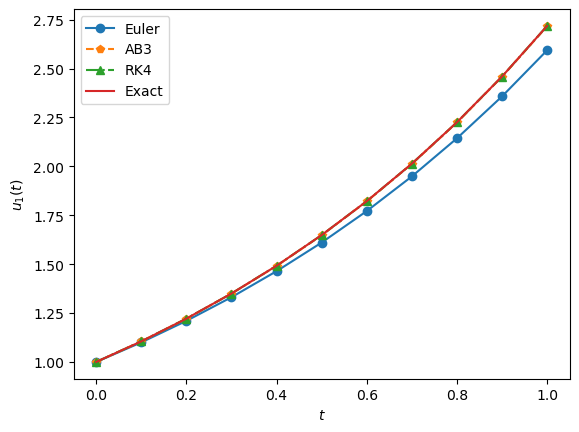

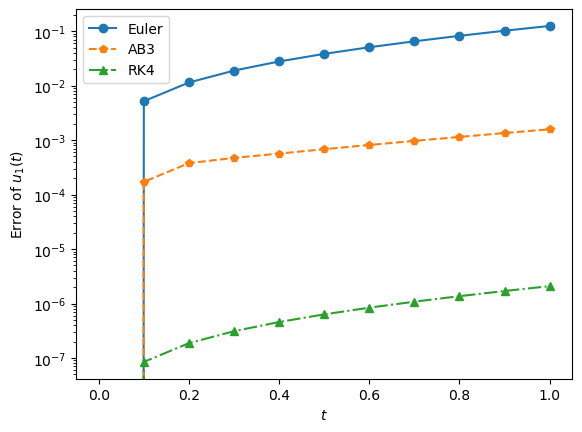

PyObject <matplotlib.legend.Legend object at 0x000000006DBE4D90>

In [3]:
# exact solution
tvec = sol_Euler.t
uexact_t = zeros(2,length(tvec))
uexact_t[1,:] = [exp(t) for t in tvec]
uexact_t[2,:] = [0.5*(exp(t)+exp(-t)) for t in tvec]

figure()
plot(tvec, sol_Euler[1,:], label="Euler","-o")
plot(tvec,sol_AB3[1,:],label="AB3","--p")
plot(tvec,sol_RK4[1,:],label="RK4","-.^")
plot(tvec, uexact_t[1,:],label="Exact")
xlabel(L"$t$")
ylabel(L"$u_1(t)$")
legend()


figure()
semilogy(tvec, abs.(sol_Euler[1,:]-uexact_t[1,:]), label="Euler","-o")
semilogy(tvec,abs.(sol_AB3[1,:]-uexact_t[1,:]),label="AB3","--p")
semilogy(tvec,abs.(sol_RK4[1,:]-uexact_t[1,:]),label="RK4","-.^")
xlabel(L"$t$")
ylabel(L"Error of $u_1(t)$")
legend()

## Zero stability

If you reduce the step size `dt`, does the error (at least) remain bounded? 

We will later learn that the following second order implicit scheme is zero-unstable.

$$u_{n+2}-3u_{n+1}+2u_n=\Delta t \left(\frac{13}{12} f_{n+2}-\frac{5}{3} f_{n+1}-\frac{5}{12} f_n\right).$$

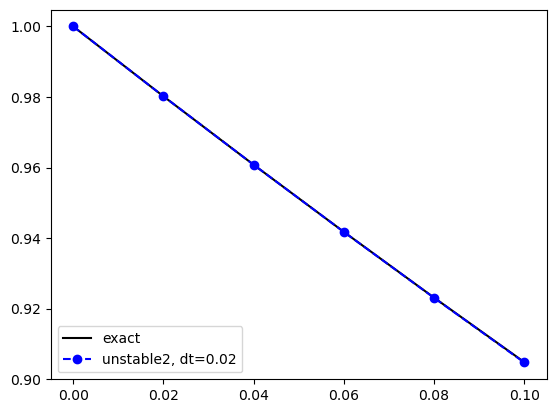

PyObject <matplotlib.legend.Legend object at 0x00000000734A6FA0>

In [4]:

function unstable2(N,T,u0)
    u = zeros(1,N+1)
    dt = T/N
    u[:,1] .= u0
    # Use a trapezoidal rule to start
    u[:,2] .= (1.0-0.5*dt)/(1.0+0.5*dt)*u[:,1]
    fu = zeros(1,N+1)
    fu[:,1] .= -u[:,1]
    fu[:,2] .= -u[:,2]
    for i = 2 : N
        u[:,i+1] .= 1.0/(1.0+13.0/12.0*dt)*(3.0*u[:,i] - 2.0*u[:,i-1] + 
            dt * (-5.0/3.0*fu[:,i] - 5.0/12.0*fu[:,i-1]))
        fu[:,i+1] .= -u[:,i+1]
    end
    return u
end

T  = 0.1
u0 = 1.0
N = 5
dt = T/N
uexact = exp(-T)
uUnstable2 = unstable2(N,T,u0)
TList=range(0,stop=T,length=N+1)


figure(1)
plot(TList,exp.(-TList),"k-",label="exact")
plot(TList,vec(uUnstable2),"b--o",label="unstable2, dt=$dt")
legend(loc="lower left")

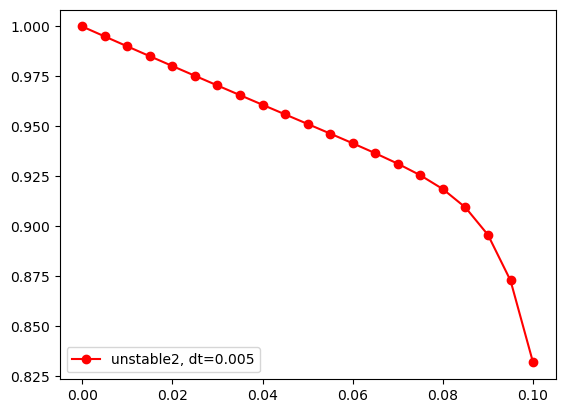

PyObject <matplotlib.legend.Legend object at 0x000000006E4A97C0>

In [5]:
N = 20
dt = T/N
uexact = exp(-T)
uUnstable2 = unstable2(N,T,u0)
TList=range(0,stop=T,length=N+1)
plot(TList,vec(uUnstable2),"r-o",label="unstable2, dt=$dt")
legend(loc="lower left")

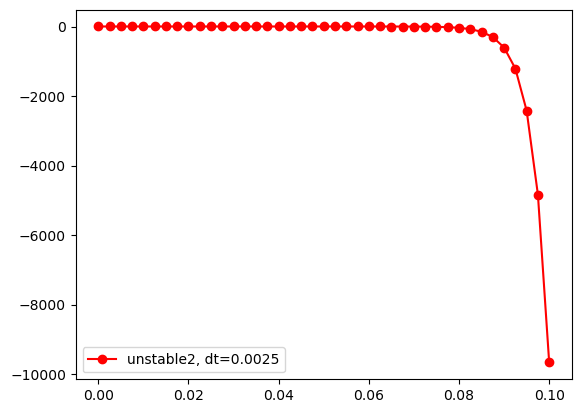

PyObject <matplotlib.legend.Legend object at 0x000000006FBF9700>

In [6]:
N = 40
dt = T/N
uexact = exp(-T)
uUnstable2 = unstable2(N,T,u0)
TList=range(0,stop=T,length=N+1)
plot(TList,vec(uUnstable2),"r-o",label="unstable2, dt=$dt")
legend(loc="lower left")

## Absolute stability, and stiffness

Given a method is zero-stable, how far can one push the step size `dt`? 

Is it possible that some methods allow much larger `dt` than others?

The Prothero-Robinson example:

$$u'=\lambda(u-\varphi(t)),\quad \lambda=-100, \quad \varphi(t)=\cos t.$$

General solution

$$u(t)=e^{\lambda t} u_0 - \lambda \int_0^t e^{\lambda(t-s)}\varphi(s) ds\approx \varphi(t)+O(|\lambda|^{-1})$$

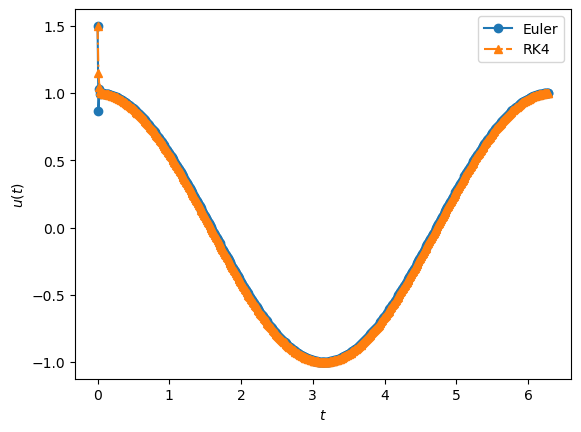

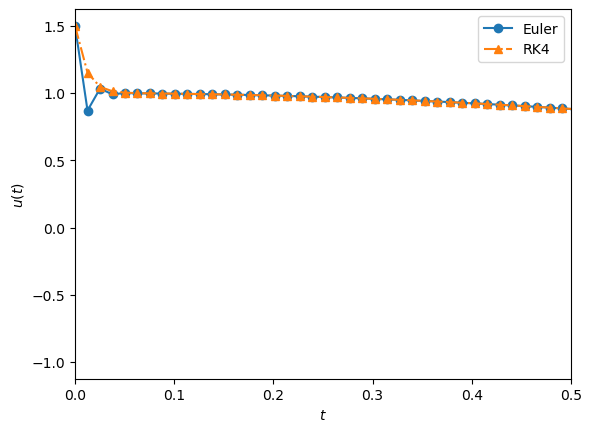

(0.0, 0.5)

In [2]:
function f_pr(du,u,p,t)
    lambda = p[1]
    du[1] = lambda * (u[1]-cos(t))
end
    
u0=[1.5]
lambda=-100.0
tspan = (0.0,2.0*pi)
tvec = LinRange(tspan[1],tspan[2],500)
dt = tvec[2]-tvec[1]
prob = ODEProblem(f_pr,u0,tspan,[lambda])

# First solve with non-stiff solvers with a small dt.
# You can try to see what happens when you increase dt.
sol_Euler = solve(prob,Euler(),dt=dt);
sol_RK4 = solve(prob,RK4(),dt=dt,adaptive=false);

figure(1)
plot(tvec, sol_Euler[1,:], label="Euler","-o")
plot(tvec,sol_RK4[1,:],label="RK4","-.^")

xlabel(L"$t$")
ylabel(L"$u(t)$")
legend()

figure(2)
plot(tvec, sol_Euler[1,:], label="Euler","-o")
plot(tvec,sol_RK4[1,:],label="RK4","-.^")

xlabel(L"$t$")
ylabel(L"$u(t)$")
legend()
xlim([0.0,0.5])



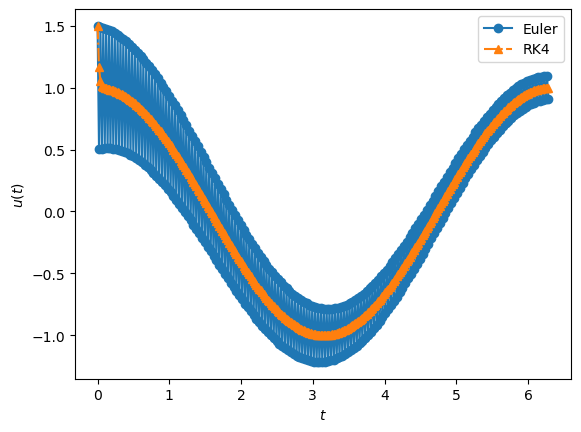

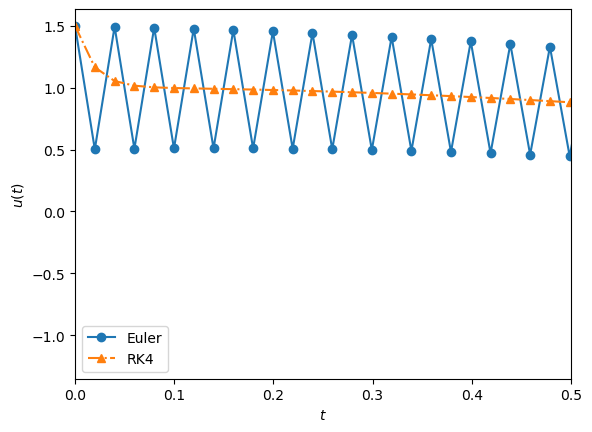

(0.0, 0.5)

In [17]:
# Let us now slightly increase dt. Euler fails first. 
# Further increase of dt will make RK4 fail as well

tspan = (0.0,2.0*pi)
tvec = LinRange(tspan[1],tspan[2],316)
dt = tvec[2]-tvec[1]
prob = ODEProblem(f_pr,u0,tspan,[lambda])

# First solve with non-stiff solvers with a small dt.
# You can try to see what happens when you increase dt.
sol_Euler = solve(prob,Euler(),dt=dt);
sol_RK4 = solve(prob,RK4(),dt=dt,adaptive=false);

figure(1)
plot(tvec, sol_Euler[1,:], label="Euler","-o")
plot(tvec,sol_RK4[1,:],label="RK4","-.^")

xlabel(L"$t$")
ylabel(L"$u(t)$")
legend()

figure(2)
plot(tvec, sol_Euler[1,:], label="Euler","-o")
plot(tvec,sol_RK4[1,:],label="RK4","-.^")

xlabel(L"$t$")
ylabel(L"$u(t)$")
legend()
xlim([0.0,0.5])


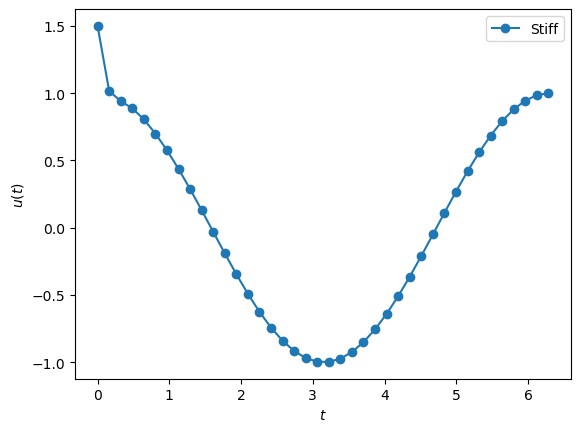

PyObject <matplotlib.legend.Legend object at 0x00000000070A14C0>

In [8]:
# Then solve with a stiff solver. Allowing a much larger dt

tvec = LinRange(tspan[1],tspan[2],40)
dt = tvec[2]-tvec[1]
prob = ODEProblem(f_pr,u0,tspan,[lambda])

sol_Stiff = solve(prob,ABDF2(),dt=dt,adaptive=false)
figure()
plot(tvec,sol_Stiff[1,:], label="Stiff","-o")

xlabel(L"$t$")
ylabel(L"$u(t)$")
legend()
#xlim([0.0,0.5])

## Hamiltonian systems

How to propagate systems with a conserved quantity for a long time?

The equation (called a Hamiltonian system)
$$\dot{x}=v, \quad \dot{v}=-x$$
preserves the total energy
$$
E=\frac12 (v^2+x^2).
$$

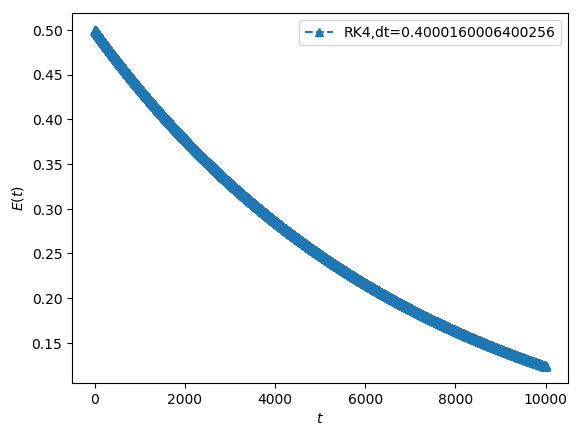

PyObject <matplotlib.legend.Legend object at 0x000000005FED7278>

In [9]:
function f_oscillator(du,u,p,t)
    du[1] = u[2]
    du[2] = -u[1]
end

u0=[0.0,1.0]
tspan = (0.0,10000.0)
tvec = LinRange(tspan[1],tspan[2],25000)
dt = tvec[2]-tvec[1]
prob = ODEProblem(f_oscillator,u0,tspan)


# Use a non-symplectic integrator with a small time step
sol_RK4 = solve(prob,RK4(),dt=dt,adaptive=false);
E_RK4 = [0.5*(x^2+v^2) for (x,v) in zip(sol_RK4[1,:],sol_RK4[2,:])]

figure()
plot(sol_RK4.t,E_RK4,label="RK4,dt=$dt","--^")

xlabel(L"$t$")
ylabel(L"$E(t)$")
legend()

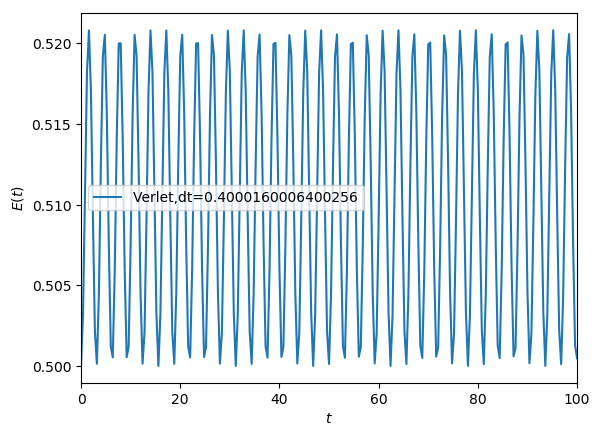

(0, 100)

In [10]:
# Use an explicit symplectic integrator with the same time step
# The VelocityVerlet method requires setting up the problem as a Hamiltonian system

Ham(p,q,params)=0.5*(p^2+q^2)

tvec = LinRange(tspan[1],tspan[2],25000)
dt = tvec[2]-tvec[1]
# Note that p appears before q in Ham.
prob = HamiltonianProblem(Ham,u0[2],u0[1],tspan)

sol_Verlet = solve(prob,VelocityVerlet(),dt=dt);

E_Verlet = [0.5*(x^2+v^2) 
    for (x,v) in zip(sol_Verlet[1,:],sol_Verlet[2,:])]

figure()
plot(sol_Verlet.t,E_Verlet,label="Verlet,dt=$dt","-")

xlabel(L"$t$")
ylabel(L"$E(t)$")
legend()
xlim([0,100])

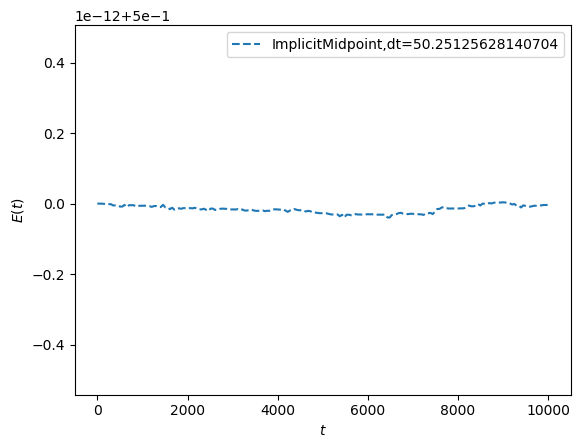

PyObject <matplotlib.legend.Legend object at 0x000000005FFA2D68>

In [11]:
# Use an implicit symplectic integrator with a much large time step

tvec = LinRange(tspan[1],tspan[2],200)
dt = tvec[2]-tvec[1]
prob = ODEProblem(f_oscillator,u0,tspan)

sol_Symplectic = solve(prob,ImplicitMidpoint(),dt=dt);

E_Symplectic = [0.5*(x^2+v^2) for (x,v) in zip(sol_Symplectic[1,:],sol_Symplectic[2,:])]

figure()
plot(sol_Symplectic.t,E_Symplectic,label="ImplicitMidpoint,dt=$dt","--")

xlabel(L"$t$")
ylabel(L"$E(t)$")
legend()

## Other topics that will be covered by this class

- How to solve large scale nonlinear problems?
- How to solve large scale linear problems?
- Connection between machine learning and ODEs? (Hint: there is something called the [Neural ODE](https://papers.nips.cc/paper/7892-neural-ordinary-differential-equations.pdf))